## Table of Content
1. [Load Data](#Load-Data)
2. [Feature Extraction](#Feature-Extraction)
3. [TimeSeriesSplit](#TimeSeriesSplit)
4. [Transform to Supervised Setup](#transform-to-supervised-setup)
5. [Train LSTM-based autoencoder](#train-lstm-based-autoencoder)
6. [Train MLP regressor](#train-mlp-regressor)
7. [Feedback Needed](#feedback-needed)
8. [Appendix: Data Preparation](#appendix-data-preparation)

## Project Goal

The goal of this project is to predict 20-day return of stock `AAPL`. While modern advances in transformers are promising for time-series forecasting, recent works show that MLPs and linear models have comparable capabilities in some tasks. Inspired by such work, we implement an ensemble of linear models with different lookback period to predict 20-day return of stock `AAPL`. We first obtain the raw data of quotes, financials, and fundamentals from yahoo finance. Then, we unify and preprocess the data format into a single `DataFrame`(see [Appendix](#appendix-data-preparation) for more details). With an unified data, we extract features of technical indicators from the data, split into train-val-test sets, standardize them, and then transform into a supervised setup. To denoise the data, we perform dimensionality reduction through training an autoencoder. Finally, we train multiple MLPs on the reduced data to perform forecasting.

## Load Data

The data loaded here has been combined and unified from multiple raw data sources. The dates are restricted to 2013/05/06 - 2023/04/26.

In [12]:
import pandas as pd
data = pd.read_csv('../prepared_data/data.csv')
data.columns

Index(['Unnamed: 0', 'Date', 'Open', 'Close', 'High', 'Low', 'Volume',
       'S&P500', 'PeRatio', 'PsRatio', 'PbRatio',
       'EnterpriseValueRevenueRatio', 'EnterpriseValueEDITDARatio',
       'BasicEPS'],
      dtype='object')

## Feature Extraction

The goal is to get these technical indicators. Most of them are implemented using an open-source library [`stock_indicators`](https://python.stockindicators.dev/).

- $n$-day return
- Typical Price = average of high, low, and close
- [Relative Strength Index](https://en.wikipedia.org/wiki/Relative_strength_index)
- [Stochastic Oscillator](https://en.wikipedia.org/wiki/Stochastic_oscillator)
- [Williams %R](https://www.investopedia.com/terms/w/williamsr.asp)
- [Moving Average Convergence Divergence(MACD)](https://www.investopedia.com/terms/m/macd.asp#:~:text=Moving%20average%20convergence%2Fdivergence%20(MACD%2C%20or%20MAC%2DD,from%20the%2012%2Dperiod%20EMA.)) = Short lookback EMA - Long lookback EMA
- [On-Balance Volume (OBV)](https://www.investopedia.com/terms/o/onbalancevolume.asp): Volume-based momentum
- [Commodity Channel Index (CCI)](https://www.investopedia.com/terms/c/commoditychannelindex.asp#:~:text=The%20Commodity%20Channel%20Index%20(CCI)%20is%20a%20technical%20indicator%20that,is%20below%20the%20historic%20average.): Evaluate the current price as opposed to the historical price
- $n$ days Moving Average
    - Simple Moving Average
    - Smoothed Moving Average
    - Exponential Moving Average
- [Average True Range (ATR)](https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/atr#:~:text=Average%20True%20Range%20(ATR)%20is,daily%2C%20weekly%2C%20or%20monthly.): The average of the true range as a way to evaluate the volatility

In [13]:
import numpy as np
from stock_indicators import Quote, indicators
from datetime import datetime

def data_to_quotes(data): 
    # Transform the date dtype to be compatible with stock_indicators pkg
    data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")
    # A list of Quotes for using stock_indicators
    aapl = [
        Quote(d,o,h,l,c,v) 
        for d,o,h,l,c,v 
        in zip(data['Date'], data['Open'], data['High'], data['Low'], data['Close'], data['Volume'])
    ]
    return aapl

def n_day_return(X, n): 
    '''
    n-day return is (current day closing price - n days ago opening price) / n days ago opening price. 
    
    Args: 
        X (np.ndarray): 
            np.ndarray with open, close 
        n (int): 
            The number of days ago. 
        
    Returns: 
        n_day_return (np.array): 
            An array of n-day return with shape (len(X),) where the first n entries would be none
    '''
    op = np.array(X.Open[:-n])
    cls = np.array(X.Close[n:])
    ret = (cls - op) / (op)
    res =  np.concatenate(([None for i in range(n)], ret), axis=0)
    return res.reshape((-1, 1))
    
def typical_price(X): 
    '''
    Typical price is the average of close, high, and low prices. 
    
    Args:
        X (np.ndarray): 
            np.ndarray with close, high, low columns. 
        
    Returns: 
        typical_price (np.array): 
            An array of typical price
    '''
    return (X.high + X.low + X.close) / 3

def relative_strength_index(quotes, n): 
    rsi_results = indicators.get_rsi(quotes, n) 
    rsi = []
    for rsi_result in rsi_results: 
        rsi.append(rsi_result.rsi)
    return np.array(rsi).reshape((-1, 1)) 

def stochastic_oscillator(quotes, n): 
    stoch_results = indicators.get_stoch(quotes, lookback_periods=n)
    stoch = [] 
    for stoch_result in stoch_results: 
        stoch.append(stoch_result.oscillator) 
    return np.array(stoch).reshape((-1, 1)) 

def william_r(quotes, n): 
    william_r_results = indicators.get_williams_r(quotes, lookback_periods=n)
    william_r = [] 
    for william_r_result in william_r_results: 
        william_r.append(william_r_result.williams_r)
    return np.array(william_r).reshape((-1, 1)) 

def macd(quotes, short_period, long_period): 
    macd_results = indicators.get_macd(quotes, fast_periods=short_period, slow_periods=long_period)
    macd = [] 
    for macd_result in macd_results: 
        macd.append(macd_result.macd) 
    return np.array(macd).reshape((-1, 1)) 

def on_balanced_volume(quotes, n): 
    obv_results = indicators.get_obv(quotes, sma_periods=n) 
    obv = []
    for obv_result in obv_results: 
        obv.append(obv_result.obv)
    return np.array(obv).reshape((-1, 1))

def commodity_channel_index(quotes, n): 
    cci_results = indicators.get_cci(quotes, lookback_periods=n)
    cci = []
    for cci_result in cci_results: 
        cci.append(cci_result.cci) 
    return np.array(cci).reshape((-1, 1)) 

def simple_moving_average(quotes, n): 
    sma_results = indicators.get_sma(quotes, n) 
    sma = []
    for sma_result in sma_results: 
        sma.append(sma_result.sma) 
    return np.array(sma).reshape((-1, 1))  

def smoothed_moving_average(quotes, n): 
    smma_results = indicators.get_smma(quotes, n) 
    smma = []
    for smma_result in smma_results: 
        smma.append(smma_result.smma)
    return np.array(smma).reshape((-1, 1))  

def exponential_moving_average(quotes, n): 
    ema_results = indicators.get_ema(quotes, n) 
    ema = []
    for ema_result in ema_results: 
        ema.append(ema_result.ema) 
    return np.array(ema).reshape((-1, 1)) 

def average_true_range(quotes, n): 
    atr_results = indicators.get_atr(quotes, n) 
    atr = [] 
    for atr_result in atr_results: 
        atr.append(atr_result.atr) 
    return np.array(atr).reshape((-1, 1)) 

We use a column transformer to concatenate all extracted features

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

# Concatenate the columns
n = 20
short_period = n // 2 
long_period = n

transformer = ColumnTransformer([
    ('original_features', 'passthrough', data.columns),
    ('rsi', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('rsi', FunctionTransformer(relative_strength_index, kw_args={'n': n}))
    ]), data.columns),
    ('stoch', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('stoch', FunctionTransformer(stochastic_oscillator, kw_args={'n': n}))
    ]), data.columns),
    ('william_r', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('william_r', FunctionTransformer(william_r, kw_args={'n': n}))
    ]), data.columns),
    ('macd', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('macd', FunctionTransformer(macd, kw_args={'short_period': short_period, 'long_period': long_period}))
    ]), data.columns),
    ('obv', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('obv', FunctionTransformer(on_balanced_volume, kw_args={'n': n}))
    ]), data.columns),
    ('cci', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('cci', FunctionTransformer(commodity_channel_index, kw_args={'n': n}))
    ]), data.columns),
    ('sma', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('sma', FunctionTransformer(simple_moving_average, kw_args={'n': n}))
    ]), data.columns),
    ('smma', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('smma', FunctionTransformer(smoothed_moving_average, kw_args={'n': n}))
    ]), data.columns),
    ('ema', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('ema', FunctionTransformer(exponential_moving_average, kw_args={'n': n}))
    ]), data.columns),
    ('atr', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('atr', FunctionTransformer(average_true_range, kw_args={'n': n}))
    ]), data.columns),
    ('5_day_return', FunctionTransformer(n_day_return, kw_args={'n': 5}), ['Open', 'Close']), 
    ('10_day_return', FunctionTransformer(n_day_return, kw_args={'n': 10}), ['Open', 'Close']), 
    ('n_day_return', FunctionTransformer(n_day_return, kw_args={'n': n}), ['Open', 'Close']),
    ('20_day_return', FunctionTransformer(n_day_return, kw_args={'n': 20}), ['Open', 'Close']), 
], remainder='passthrough')

# Drop the first and the second column which is indices and dates
full_data = transformer.fit_transform(data)[:, 1:]

Since some of the technical indicators require lookback, the first $n$ points would contain `None`. We choose to drop those data points.

In [15]:
prefix = 0 
while prefix < full_data.shape[0]: 
    if np.equal(full_data[prefix:], None).any():
        prefix += 1
    else: 
        break
full_data = full_data[prefix:]
print(full_data.shape)

(2491, 27)


## TimeSeriesSplit

We use [`sklearn.model_selection.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit.split) to split the data into 3-fold to train and evaluate the model. In addition, `test set` is split into `validation set` and `test set` to tune the model. 

In [16]:
from sklearn.model_selection import TimeSeriesSplit 

tscv = TimeSeriesSplit(n_splits=3, max_train_size=900) 
folds = []
for i, (train_index, test_index) in enumerate(tscv.split(full_data)):
     # First 90 dates of test set
     validation_index = test_index[:90]
     test_index = test_index[90:]
     print(f"Fold {i}:")
     print(f"  Training set size = {len(train_index)}")
     print(f"  Validation set size = {len(validation_index)}")
     print(f"  Test set size = {len(test_index)}")
     print(f"  Training set start date = {full_data[train_index[0], 0]}")
     print(f"  Training set end date = {full_data[train_index[-1], 0]}")
     print(f"  Validation set start date = {full_data[validation_index[0], 0]}")
     print(f"  Validation set end date = {full_data[validation_index[-1], 0]}")
     print(f"  Test set start date = {full_data[test_index[0], 0]}")
     print(f"  Test set end date = {full_data[test_index[-1], 0]}")
     folds.append((train_index, validation_index, test_index))

Fold 0:
  Training set size = 625
  Validation set size = 90
  Test set size = 532
  Training set start date = 2013-06-05
  Training set end date = 2015-11-24
  Validation set start date = 2015-11-25
  Validation set end date = 2016-04-06
  Test set start date = 2016-04-07
  Test set end date = 2018-05-16
Fold 1:
  Training set size = 900
  Validation set size = 90
  Test set size = 532
  Training set start date = 2014-10-20
  Training set end date = 2018-05-16
  Validation set start date = 2018-05-17
  Validation set end date = 2018-09-24
  Test set start date = 2018-09-25
  Test set end date = 2020-11-03
Fold 2:
  Training set size = 900
  Validation set size = 90
  Test set size = 532
  Training set start date = 2017-04-10
  Training set end date = 2020-11-03
  Validation set start date = 2020-11-04
  Validation set end date = 2021-03-16
  Test set start date = 2021-03-17
  Test set end date = 2023-04-26


## Transform to Supervised Setup

A supervised setup consists of `X`, `y` where `X` are $n$ days lookback of all the features and `y` is 20-day return. In addition, to satisfy the shape requirement of using LSTM-based autoencoder, we need to shape the data to be $n \times \text{timestep} \times \text{d}$. We store all `X_train, y_train, X_val, y_val, X_test, y_test` of each fold into a `list` of `dict` called `fold_data`.

In [17]:
from sklearn.preprocessing import StandardScaler

def supervised_transformer(data, n): 
    X, y = data 
    X_result = np.ndarray((X.shape[0]-n, n, X.shape[1]))
    y_result = y[n:]
    for i in range(n, X.shape[0]): 
        X_result[i-n] = X[i-n:i]
    
    print(f'X\'s shape = {X_result.shape}')
    print(f'y\'s shape = {y_result.shape}')
    return X_result, y_result

n = 20
fold_data = []

for (train_index, validation_index, test_index) in folds: 
    X_train = full_data[train_index, 1:]
    y_train = full_data[train_index, -1]
    X_val = full_data[validation_index, 1:]
    y_val = full_data[validation_index, -1]
    X_test = full_data[test_index, 1:]
    y_test = full_data[test_index, -1]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    X_train, y_train = supervised_transformer((X_train, y_train), n)
    X_val, y_val = supervised_transformer((X_val, y_val), n)
    X_test, y_test = supervised_transformer((X_test, y_test), n)
    fold_data.append({
        'X_train': X_train, 
        'y_train': y_train,
        'X_val': X_val, 
        'y_val': y_val, 
        'X_test': X_test, 
        'y_test': y_test
    })

X's shape = (605, 20, 26)
y's shape = (605,)
X's shape = (70, 20, 26)
y's shape = (70,)
X's shape = (512, 20, 26)
y's shape = (512,)
X's shape = (880, 20, 26)
y's shape = (880,)
X's shape = (70, 20, 26)
y's shape = (70,)
X's shape = (512, 20, 26)
y's shape = (512,)
X's shape = (880, 20, 26)
y's shape = (880,)
X's shape = (70, 20, 26)
y's shape = (70,)
X's shape = (512, 20, 26)
y's shape = (512,)


## Train LSTM-based autoencoder

Financial time series data is generally more noisy than typical dataset. There are a number of denoising technique such as Principle Component Analysis(PCA), Exponential Smoothing, and other dimensionality reduction methods. Here we adopt LSTM-based autoencoder because LSTM captures the lookback property of the data we are dealing with and we do need some sort of long term memory as a way to encode previous days features. The idea of autoencoder is a neural network composed of two parts: Encoder and Decoder. Encoder takes a high dimensional input space and compress it through some layers into a lower dimensional hidden layer. Decoder reverses the process by taking the lower dimensional hidden layer reduced by Encoder and decompress it through some layers mirroring the dimension of the Encoder and restore the original input. This way, when the neural network forward passes to the lower dimensional space at the end of the Encoder, it does the dimensionality reduction and denoises the input data. The Decoder can be viewed as reconstructing the input through the lower dimension representation of the input. Training the autoencoder can be interpreted as dimensionality reduction that reaches the lowest reconstruction error. The following implementation is inspired [here](https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352)

### `AutoEncoder`, `Encoder`, and `Decoder`

In [18]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Layer
import keras
import tensorflow as tf

class Encoder(keras.layers.Layer): 
    def __init__(self, h1, h2, time_steps, n_features, l2_alpha=0.02, **kwargs): 
        super(Encoder, self).__init__(**kwargs)
        self.layer1 = LSTM(h1, activation='relu', input_shape=(time_steps, n_features), return_sequences=True, kernel_regularizer=tf.keras.regularizers.L2(l2_alpha))
        self.layer2 = LSTM(h2, activation='relu', return_sequences=False)
    
    def call(self, x):
        x = self.layer1(x)
        return self.layer2(x)

class Decoder(keras.layers.Layer): 
    def __init__(self, h1, h2, time_steps, n_features, l2_alpha=0.02, **kwargs): 
        super(Decoder, self).__init__(**kwargs)
        self.layer1 = LSTM(h2, activation='relu', return_sequences=True)
        self.layer2 = LSTM(h1, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.L2(l2_alpha))
        self.time_distributed = TimeDistributed(Dense(n_features, kernel_regularizer=tf.keras.regularizers.L2(l2_alpha)))
    
    def call(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return self.time_distributed(x)
    
class AutoEncoder(tf.keras.Model): 
    def __init__(self, h1, h2, time_steps, n_features, l2_alpha=0.02, **kwargs): 
        super(AutoEncoder, self).__init__(**kwargs)
        self.h1 = h1 
        self.h2 = h2 
        self.time_steps = time_steps 
        self.n_features = n_features
        self.encoder = Encoder(h1, h2, time_steps, n_features, l2_alpha)
        self.repeat = RepeatVector(time_steps)
        self.decoder = Decoder(h1, h2, time_steps, n_features, l2_alpha)
    
    def call(self, x): 
        x = self.encoder(x) 
        x = self.repeat(x) 
        return self.decoder(x)
        

### Training

In [19]:
def train_step(x, model, optimizer, loss_fn):
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        # Forward pass.
        pred = model(x)
        # Loss value for this batch.
        loss_value = loss_fn(x, pred)
    # Get gradients of loss wrt the weights.
    gradients = tape.gradient(loss_value, model.trainable_weights)
    # Update the weights of the model.
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    return loss_value

def validate_step(x, model, loss_fn): 
    val_pred = model(x)
    loss_value = loss_fn(x, val_pred)
    return loss_value

def train_autoencoder(train_dataloader, val_dataloader, epochs, optimizer=None, lr_schedule=None, pretrain_path=None, loss_fn=tf.keras.losses.MeanSquaredError(), args: dict = None):
    if lr_schedule is None: 
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=args['learning_rate'],
            decay_steps=10000,
            decay_rate=0.9)
    if optimizer is None: 
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    best_val_loss = None 
    lr = args['learning_rate']
    alpha = args['alpha']
    best_path = f'model_best_lr_{lr}_alpha_{alpha}'
    train_losses = []
    val_losses = []
    for epoch in range(epochs): 
        print(f'Start of {epoch + 1} epoch')
        train_loss = 0
        for x in train_dataloader: 
            loss_value = train_step(x, model, optimizer, loss_fn)
            train_loss += loss_value
    
        print(f'Train MSE = {train_loss}')

        val_loss = 0
        for val_x in val_dataloader: 
            loss_value = validate_step(val_x, model, loss_fn)
            val_loss += loss_value 
        
        print(f'Validation MSE = {val_loss}')
        print()
        
        val_loss = val_loss / len(val_dataloader)

        if best_val_loss is None or val_loss < best_val_loss: 
            best_val_loss = val_loss
            model.save(best_path)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss) 
    
    model.save('model_latest')
    return train_losses, val_losses

n = 20
d = full_data.shape[1] - 1
epochs = 60

X_train = fold_data[0]['X_train']
X_val = fold_data[0]['X_val']
# Initialize the dataset
batch_size = 2048
train_dataset = tf.data.Dataset.from_tensor_slices((X_train))
train_dataloader = train_dataset.batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val))
val_dataloader = val_dataset.batch(batch_size)
args = {
    'learning_rate': 1e-3, 
    'alpha': 0.01
}
lr = args['learning_rate']
alpha = args['alpha']
# model = keras.models.load_model("after_300_epochs")
model = AutoEncoder(64, 20, n, d, l2_alpha=args['alpha'])
# Learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=args['learning_rate'],
    decay_steps=10000,
    decay_rate=0.9)
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# Instantiate a loss function
loss_fn = tf.keras.losses.MeanSquaredError()
train_history, val_history = train_autoencoder(train_dataloader, val_dataloader, epochs, args=args)

Start of 1 epoch
Train MSE = 0.9970384836196899
Validation MSE = 1.2757267951965332

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 2 epoch
Train MSE = 0.9924031496047974
Validation MSE = 1.275163173675537

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 3 epoch
Train MSE = 0.9902886152267456
Validation MSE = 1.27377188205719

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 4 epoch
Train MSE = 0.9878172278404236
Validation MSE = 1.2710115909576416

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 5 epoch
Train MSE = 0.9839625954627991
Validation MSE = 1.2679673433303833

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 6 epoch
Train MSE = 0.9781633019447327
Validation MSE = 1.2746883630752563

Start of 7 epoch
Train MSE = 0.9703357815742493
Validation MSE = 1.3121968507766724

Start of 8 epoch
Train MSE = 0.9616309404373169
Validation MSE = 1.3408564329147339

Start of 9 epoch
Train MSE = 0.950889527797699
Validation MSE = 1.3462653160095215

Start of 10 epoch
Train MSE = 0.938669741153717
Validation MSE = 1.337920904159546

Start of 11 epoch
Train MSE = 0.9244376420974731
Validation MSE = 1.2987297773361206

Start of 12 epoch
Train MSE = 0.9102305769920349
Validation MSE = 1.2768336534500122

Start of 13 epoch
Train MSE = 0.8929364681243896
Validation MSE = 1.2670447826385498

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 14 epoch
Train MSE = 0.875214695930481
Validation MSE = 1.266700029373169

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 15 epoch
Train MSE = 0.8574428558349609
Validation MSE = 1.2636722326278687

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 16 epoch
Train MSE = 0.8380926847457886
Validation MSE = 1.256905436515808

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 17 epoch
Train MSE = 0.8214172720909119
Validation MSE = 1.2478995323181152

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 18 epoch
Train MSE = 0.7983989715576172
Validation MSE = 1.2450554370880127

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 19 epoch
Train MSE = 0.7800053954124451
Validation MSE = 1.2483394145965576

Start of 20 epoch
Train MSE = 0.7637895345687866
Validation MSE = 1.2541663646697998

Start of 21 epoch
Train MSE = 0.7461537718772888
Validation MSE = 1.2629245519638062

Start of 22 epoch
Train MSE = 0.7282047271728516
Validation MSE = 1.276895523071289

Start of 23 epoch
Train MSE = 0.7112744450569153
Validation MSE = 1.2873315811157227

Start of 24 epoch
Train MSE = 0.6917046904563904
Validation MSE = 1.2913212776184082

Start of 25 epoch
Train MSE = 0.6703009009361267
Validation MSE = 1.290921688079834

Start of 26 epoch
Train MSE = 0.651451051235199
Validation MSE = 1.292509913444519

Start of 27 epoch
Train MSE = 0.6350303292274475
Validation MSE = 1.299422264099121

Start of 28 epoch
Train MSE = 0.6167251467704773
Validation MSE = 1.3052831888198853

Start of 29 epoch
Train MSE = 0.5981000065803528
Validation MSE = 1.2997444868087769

Start of 30 epoch
Train MSE = 0.5818895697593689
Validation

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 34 epoch
Train MSE = 0.5168449878692627
Validation MSE = 1.2177008390426636

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 35 epoch
Train MSE = 0.5021260380744934
Validation MSE = 1.207857370376587

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 36 epoch
Train MSE = 0.4883868396282196
Validation MSE = 1.2005317211151123

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 37 epoch
Train MSE = 0.47751104831695557
Validation MSE = 1.1879286766052246

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 38 epoch
Train MSE = 0.4631851315498352
Validation MSE = 1.1767929792404175

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 39 epoch
Train MSE = 0.452168732881546
Validation MSE = 1.1699353456497192

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 40 epoch
Train MSE = 0.4421585500240326
Validation MSE = 1.1542739868164062

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 41 epoch
Train MSE = 0.4333084523677826
Validation MSE = 1.1298846006393433

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 42 epoch
Train MSE = 0.4244650900363922
Validation MSE = 1.1041994094848633

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 43 epoch
Train MSE = 0.41755980253219604
Validation MSE = 1.0924564599990845

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 44 epoch
Train MSE = 0.4096514880657196
Validation MSE = 1.0857330560684204

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 45 epoch
Train MSE = 0.40273433923721313
Validation MSE = 1.0784200429916382

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 46 epoch
Train MSE = 0.395599901676178
Validation MSE = 1.0731778144836426

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 47 epoch
Train MSE = 0.38910239934921265
Validation MSE = 1.072102665901184

INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


INFO:tensorflow:Assets written to: model_best_lr_0.001_alpha_0.01/assets


Start of 48 epoch
Train MSE = 0.38263535499572754
Validation MSE = 1.0733642578125

Start of 49 epoch
Train MSE = 0.37617436051368713
Validation MSE = 1.080893874168396

Start of 50 epoch
Train MSE = 0.37012940645217896
Validation MSE = 1.0871683359146118

Start of 51 epoch
Train MSE = 0.364838570356369
Validation MSE = 1.0943351984024048

Start of 52 epoch
Train MSE = 0.35819217562675476
Validation MSE = 1.093336820602417

Start of 53 epoch
Train MSE = 0.3533358573913574
Validation MSE = 1.0924713611602783

Start of 54 epoch
Train MSE = 0.3543661832809448
Validation MSE = 1.094939112663269

Start of 55 epoch
Train MSE = 0.34584903717041016
Validation MSE = 1.0980751514434814

Start of 56 epoch
Train MSE = 0.34897759556770325
Validation MSE = 1.1179240942001343

Start of 57 epoch
Train MSE = 0.3435927629470825
Validation MSE = 1.1335715055465698

Start of 58 epoch
Train MSE = 0.3458394408226013
Validation MSE = 1.133163332939148

Start of 59 epoch
Train MSE = 0.3368227481842041
Validat

INFO:tensorflow:Assets written to: model_latest/assets


### Learning Curve

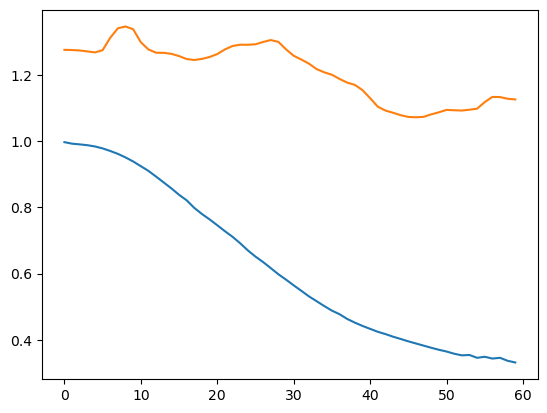

In [20]:
import matplotlib.pyplot as plt 
plt.plot(train_history, label='train loss')
plt.plot(val_history, label='validation loss')

### Visualization of 20-day return reconstruction in `training set` and `validation set`

16/16 [==============================] - 2s 145ms/step


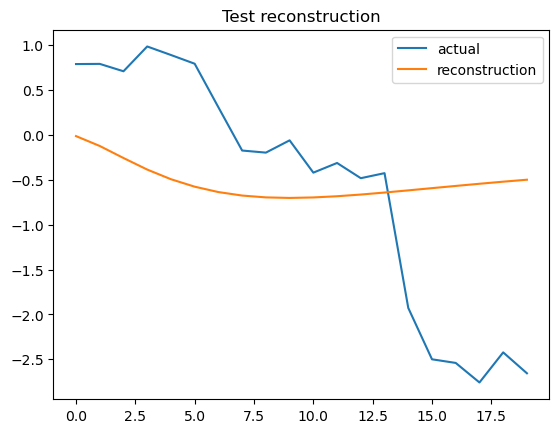

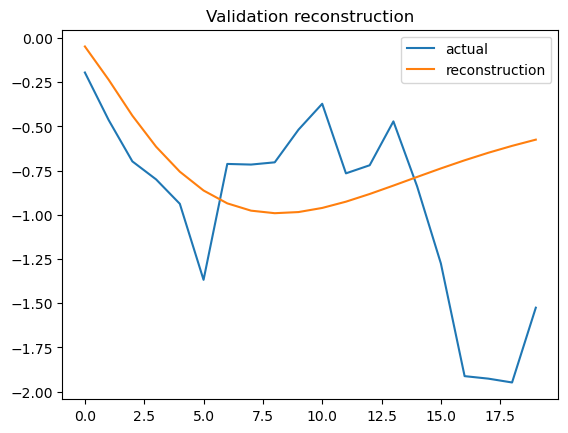

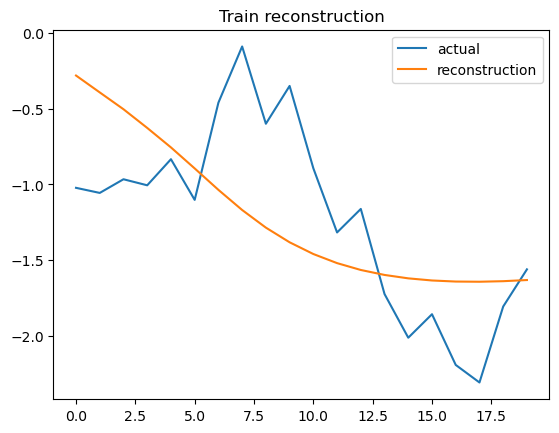

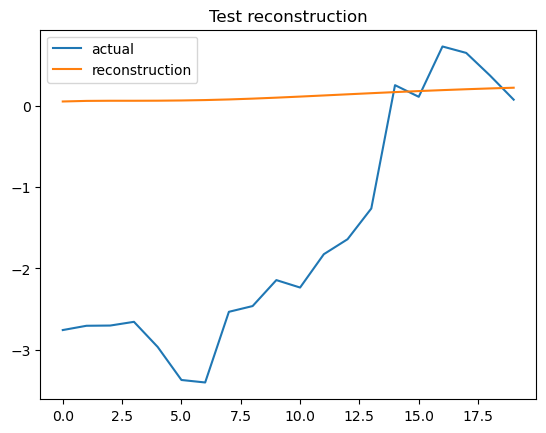

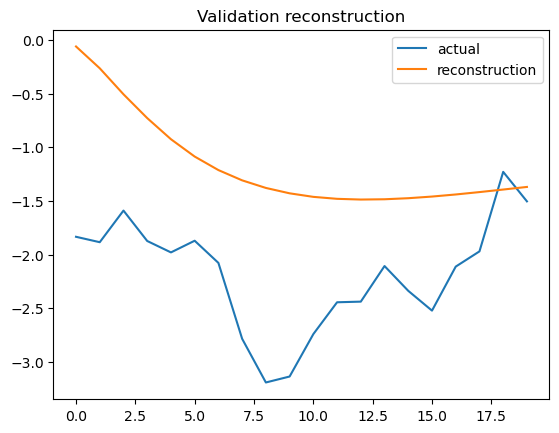

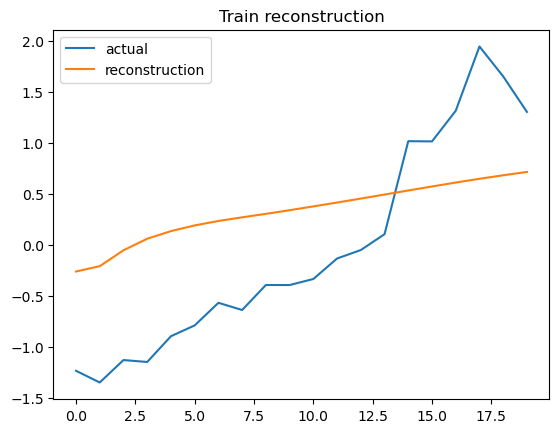

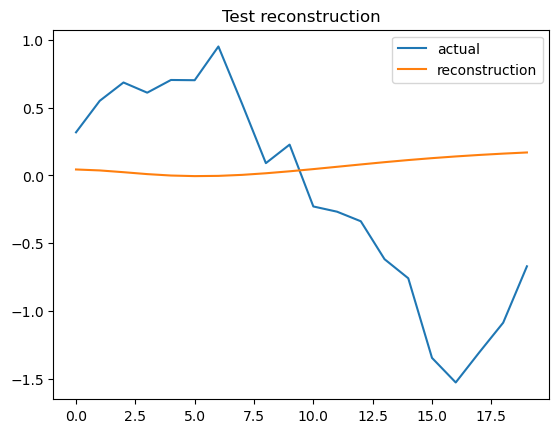

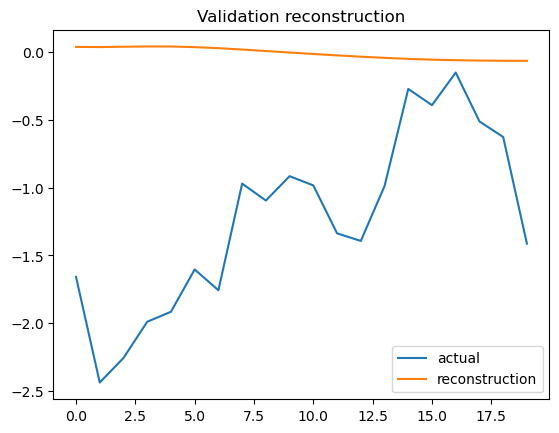

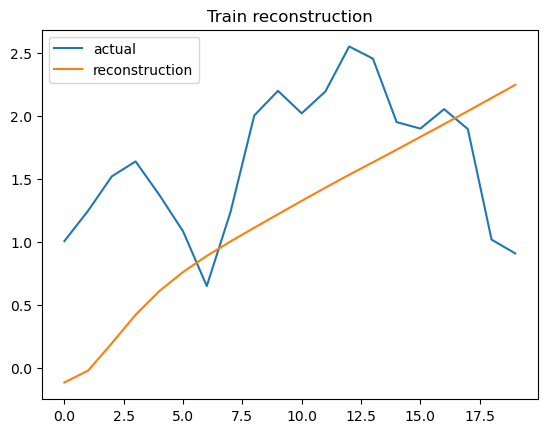

In [21]:
model = keras.models.load_model(f'model_best_lr_{lr}_alpha_{alpha}')
X_train = fold_data[0]['X_train']
X_val = fold_data[0]['X_val']
X_test = fold_data[0]['X_test']
X_hat = model.predict(X_train)
X_hat_val = model.predict(X_val)
X_hat_test = model.predict(X_test)

for i in range(3):
    fig = plt.figure()
    plt.plot(range(n), X_test[i * 20, :n, -1], label='actual')
    plt.plot(range(n), X_hat_test[i * 20, :n, -1], label='reconstruction')
    plt.legend()
    plt.title('Test reconstruction')
    fig = plt.figure()
    plt.plot(range(n), X_val[i * 20, :n, -1], label='actual')
    plt.plot(range(n), X_hat_val[i * 20, :n, -1], label='reconstruction')
    plt.legend()
    plt.title('Validation reconstruction')
    fig = plt.figure()
    plt.plot(range(n), X_train[i * 20, :n, -1], label='actual')
    plt.plot(range(n), X_hat[i * 20, :n, -1], label='reconstruction')
    plt.title('Train reconstruction')
    plt.legend()

## Train MLP Regressor

In [22]:
class NLinear(tf.keras.Model):
    def __init__(self, H: int):
        super(NLinear, self).__init__()
        self.dense = Dense(H, use_bias=True)

    def call(self, x):
        last_val = tf.reshape(x[:, -1], shape=(-1, 1))
        x = x - last_val
        y = self.dense(x)
        y = y + last_val
        return y

## Feedback Needed

Currently, the visualization shows that the autoencoder is overfitting. I'm trying to use `L2` regularization to avoid really huge reconstructed 20-day return. I am assuming the problem comes from different time period has a overall trend of 20-day return. Since I split the train-val-test based on `TimeSeriesSplit`, there might be a distribution shift from the training set to test set. I wonder what would be a good idea to solve this other than regularization. In addition, I'm afraid that this weak autoencoder would cause compounding error later on in forecasting.

## Appendix: Data Preparation
We have five raw datasets, each of which comes in different formats. The goal of this section is to prepare the datasets into a unified `DataFrame` with features needed by feature extraction and the same dates. Standardization and pipeline preprocessing would be in the next section.

In [23]:
import pandas as pd 
import numpy as np 

### AAPL

In [24]:
aapl = pd.read_csv('../raw_data/AAPL.csv')

# Target the time frame: 2013/05/06 - 2023/04/26
aapl = aapl[(aapl['Date'] >= '2013-05-06') & (aapl['Date'] <= '2023-04-26')]

# Get target features 
aapl_features = aapl[['Date', 'Open', 'Close', 'High', 'Low', 'Volume']]
aapl_features.shape

(2512, 6)

### Macroeconomic Variables

#### US Treasury Bill Bond (13 Weeks)

- Typical Price of US Treasury Bill Bond (13 Weeks)

In [25]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

def get_typical_price(X): 
    return np.average(X, axis=1)

risk_free = pd.read_csv('../raw_data/US_Treasury_Bond_13weeks.csv')
risk_free = risk_free.dropna()
risk_free = risk_free[risk_free['Date'] >= '2013-05-06']
transformer = FunctionTransformer(get_typical_price)
typical_price = transformer.fit_transform(risk_free[['High', 'Close', 'Low']])
risk_free = pd.DataFrame({
    'Date': risk_free['Date'], 
    'Typical Price': typical_price
})
risk_free.shape

(2512, 2)

#### S&P 500 Index

In [26]:
sp500 = pd.read_csv('../raw_data/sp500_index.csv')
sp500 = sp500[sp500['Date'] <= '2023-04-26']
sp500.shape

(2512, 2)

### Fundamentals

#### Valuation measures
- PeRatio: Share price over earnings per share
- PsRatio: Share price over sales per share
- PbRatio: Share price over book per share
- Enterprise value to revenue ratio 
- Enterprise value to EDITDA(Earnings Before Interest, Taxes, Depreciation, and Amortization) ratio

In [27]:
from datetime import datetime

val_measure = pd.read_csv('../raw_data/AAPL_quarterly_valuation_measures.csv')
# print(val_measure.columns)
peratio = val_measure[val_measure.name == 'PeRatio'].drop(columns=['ttm', 'name'])
psratio = val_measure[val_measure.name == 'PsRatio'].drop(columns=['ttm', 'name'])
pbratio = val_measure[val_measure.name == 'PbRatio'].drop(columns=['ttm', 'name'])
enterprise_val_revenue_ratio = val_measure[val_measure.name == 'EnterprisesValueRevenueRatio'].drop(columns=['ttm', 'name'])
enterprise_val_ebitda_ratio = val_measure[val_measure.name == 'EnterprisesValueEBITDARatio'].drop(columns=['ttm', 'name'])
feats = [peratio, psratio, pbratio, enterprise_val_revenue_ratio, enterprise_val_ebitda_ratio]
names = ['PeRatio', 'PsRatio', 'PbRatio', 'EnterpriseValueRevenueRatio', 'EnterpriseValueEDITDARatio']
dates = sp500.Date 

def quarterly_to_daily(quarter_data, dates, name):
    target_date = []
    for d in dates: 
        target_date.append(np.max(quarter_data.columns[quarter_data.columns <= d]))
    daily_data = np.zeros(dates.shape[0])
    for i, d in enumerate(target_date): 
        daily_data[i] = quarter_data[d]
    return pd.DataFrame({
        'Date': dates,
        name: daily_data
    })

def transform_date_format(X): 
    '''
    Transform the date format of input data's columns to format yyyy-mm-dd

    Args: 
        X: pd.DataFrame where the columns should be quarterly dates in the format mm/dd/yyyy
    Returns: 
        X_transformed: pd.DataFrame where the columns would be quarterly dates in the format yyyy-mm-dd
    '''
    dates = []
    for d in X.columns: 
        date_obj = datetime.strptime(d, '%m/%d/%Y')
        dates.append(date_obj.strftime('%Y-%m-%d'))
    X_transformed = pd.DataFrame(X.values, columns=dates)
    return X_transformed

for i, feat in enumerate(feats): 
    feats[i] = quarterly_to_daily(transform_date_format(feat), dates, names[i])

for i, feat in enumerate(feats): 
    print(feats[i].shape)

(2512, 2)
(2512, 2)
(2512, 2)
(2512, 2)
(2512, 2)


#### Financials

- BasicEPS: Earning Per Share

In [28]:
dates = sp500.Date 
fin_measure = pd.read_csv('../raw_data/AAPL_quarterly_financials.csv')
# print(fin_measure.columns)
eps = fin_measure[fin_measure.name == 'BasicEPS'].drop(columns=['ttm', 'name'])
eps = quarterly_to_daily(transform_date_format(eps), dates, 'BasicEPS')
print(eps.shape)

(2512, 2)


### Concatenate all basic features

In [29]:
joined_data = pd.merge(aapl_features, sp500, on='Date')
for f in feats: 
    joined_data = pd.merge(joined_data, f, on='Date')
joined_data = pd.merge(joined_data, eps, on='Date')
joined_data.to_csv('../prepared_data/data.csv')